In [113]:
# Read libraries and data
import torch
import pandas as pd
import requests
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Replace with the URL you copied
url = 'https://raw.githubusercontent.com/jvilchesf/Learning/main/Andrej_karpathy_videos/Makemore/names.txt'

response = requests.get(url)
words = response.text.splitlines()

In [114]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

In [115]:
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    #Creating the dataset
    context = []
    X , Y = [], []
    for w in words: 

        context = block_size * [0] 

        for i in w + '.':
            idx = stoi[i]
            X.append(context)
            Y.append(idx)
            #print(f"{context} -> {i}")
            context = context[1:] + [idx]
        #print("-----------------")

    X = torch.tensor(X)    
    Y = torch.tensor(Y)    
    print(X.shape,Y.shape)
    return X,Y

import random

random.seed(42)
random.shuffle(words)
n1 = int(len(words)*0.8)
n2 = int(len(words)*0.9)

Xtr , Ytr = build_dataset(words[:n1])
Xdev , Ydev = build_dataset(words[n1:n2])
Xte , Yte = build_dataset(words[n2: ])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [116]:
#Define the model variables W1, W2, b1, b2, C, parameters
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator = g)
C_copy = C.clone()
W1 = torch.randn((30,200), generator = g)
b1 = torch.randn(200, generator = g)
W2 = torch.randn((200,27), generator = g)
b2 = torch.randn(27, generator = g)
parameters = [C, W1, b1, W2, b2]

In [117]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [118]:
for p in parameters:
  p.requires_grad = True

In [119]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [120]:
lri = []
lossi = []
steps = []
gradi = []
loop = 200000

In [121]:
for i in range(loop):

    #batches
    idx = torch.randint(0, Xtr.shape[0], (32,)) # [32]

    #Forward
    emb = C[Xtr[idx]] # [32x3x10]
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # [32x300] 
    logits = h @ W2 + b2 # [32x27]
    loss = F.cross_entropy(logits,Ytr[idx])
    #print(loss.item())

    #Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    #update the parameters
    loops1 = loop * 0.1
    loops2 = loop * 0.5
    if i < loops1:
        lr = 0.1
    elif (i > loops1) & (i < loops2):
        lr = 0.05
    elif i > loops2:
        lr = 0.01    

    for p in parameters:
        p.data -= p.grad * lr

    if i % 1000 == 0:    
        gradi.append(lr)
        lossi.append(loss.item())
        steps.append(i) 

#Create a dataframe with the results
df = pd.DataFrame({'Steps': steps, 'Learning Rate': gradi, 'Loss': lossi})

print(loss)

tensor(1.8273, grad_fn=<NllLossBackward0>)


In [122]:
df.head(-50)

,Steps,Learning Rate,Loss
0,0,0.10,26.483313
1,1000,0.10,3.924313
2,2000,0.10,2.868943
3,3000,0.10,3.340128
4,4000,0.10,2.968286
...,...,...,...
145,145000,0.01,2.290941
146,146000,0.01,2.324138
147,147000,0.01,2.137855
148,148000,0.01,1.823098


In [123]:
# training loss 
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1676, grad_fn=<NllLossBackward0>)

In [124]:
# validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1944, grad_fn=<NllLossBackward0>)

In [125]:
# test loss
emb = C[Xte] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.2040, grad_fn=<NllLossBackward0>)

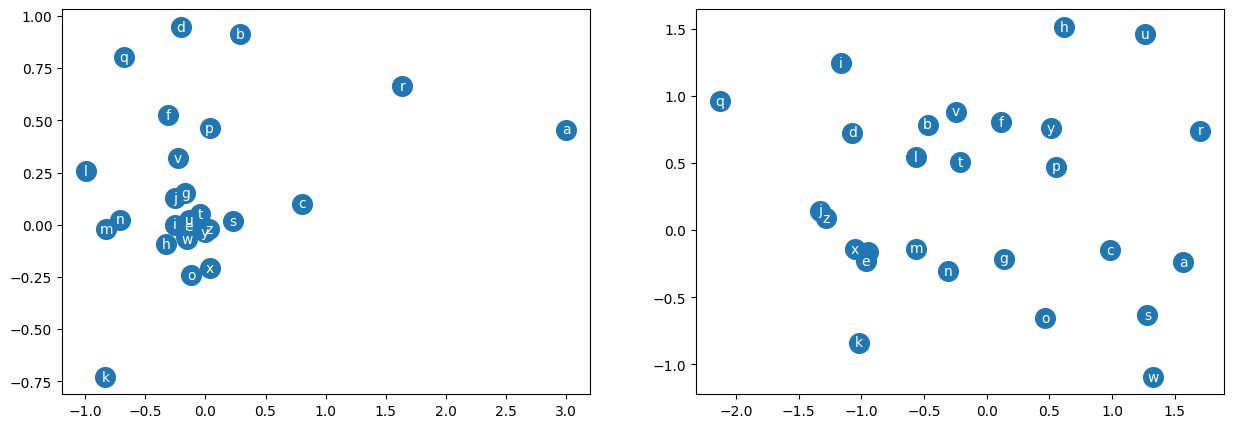

In [128]:
fig = plt.figure(figsize = (15,5))
ax1 = fig.add_subplot(1, 2, 1)
plt.scatter(C[:,0].data, C[:,1].data, s = 200)
for i in range(26):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha= 'center', va= 'center', color = 'white')

ax2 = fig.add_subplot(1, 2, 2)
plt.scatter(C_copy[:,0].data, C_copy[:,1].data, s = 200)
for i in range(26):
    plt.text(C_copy[i,0].item(), C_copy[i,1].item(), itos[i], ha= 'center', va= 'center', color = 'white')    

In [131]:
g = torch.Generator().manual_seed(2147483647 +20)
block_size = 3

for _ in range(20):

    out = []
    context = block_size * [0]
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        prob = F.softmax(logits, dim = 1)
        ix = torch.multinomial(prob, num_samples = 1, generator = g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))

KeyError: 26